In [ ]:
!pip install torch-dreams

In [ ]:
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams.dreamer import dreamer

import cv2 
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

from torch_dreams.image_transforms import resize_4d_tensor_by_size

In [ ]:
!wget -O bike.jpg "https://www.switchbacktravel.com/sites/default/files/articles%20/Mountain%20Bike%20(Santa%20Cruz%20Bronson%20-%20m).jpg"

## Preparing the image

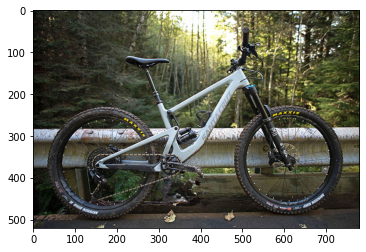

In [ ]:
im = cv2.cvtColor(cv2.imread('bike.jpg'), cv2.COLOR_BGR2RGB)/255.
height , width , channels = im.shape
plt.imshow(im)
plt.show()


In [ ]:
image_tensor = torch.tensor(im).permute(-1,0,1).unsqueeze(0)
t = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

image_tensor_transformed = t(image_tensor)

# defining a custom loss 

It aims to compare the outputs of a model's layer(s) w.r.t another set of outputs which was stored after feeding an input image to the model

In [ ]:
class SnapshotLoss(nn.Module):
    def __init__(self, ideal_layer_outputs):
        super().__init__()
        ## outputs of certain layers saved after a forward pass 
        self.ideal_layer_outputs = ideal_layer_outputs

    def forward(self,layer_outputs):
        assert len(layer_outputs) == len(self.ideal_layer_outputs)
        loss = 0.
        for i  in range(len(layer_outputs)):
        
            if layer_outputs[i].shape  ==  self.ideal_layer_outputs[i].shape:
                l  = torch.square(layer_outputs[i] - self.ideal_layer_outputs[i]).mean()
                loss += l
            else:
                ## resizing might be necessary if the input image itself gets resized 
                outs_resized = resize_4d_tensor_by_size(
                    x = layer_outputs[i].unsqueeze(0), 
                    height = self.ideal_layer_outputs[i].shape[-2],
                    width = self.ideal_layer_outputs[i].shape[-1]
                )
                l  = torch.square(outs_resized.squeeze(0) - self.ideal_layer_outputs[i]).mean()
                loss += l
        # print(loss)
        return loss 

# Experiment 1: on inception_v3

In [ ]:
model = models.inception_v3(pretrained=True)

dreamy_boi = dreamer(model, device = 'cuda', quiet= False)

layers_to_watch = [
                 model.Conv2d_4a_3x3,
                 model.Mixed_6c.branch7x7_1.conv,
                 model.Mixed_7a.branch7x7x3_1.conv
            ]

In [ ]:
img_params = []

for layer in layers_to_watch:

    # Capture and store the outputs of the layers mentioned in arg layers
    snapshot = dreamy_boi.get_snapshot(
        layers = [layer],
        input_tensor = image_tensor_transformed
    )

    snap_loss = SnapshotLoss(ideal_layer_outputs = snapshot)

    img_param = dreamy_boi.render(
        layers= [layer],
        custom_func= snap_loss,
        iters = 190,
        height= height,
        width= width,
        # weight_decay= 1e-3,
        lr = 7e-3,
        scale_min= 0.2,
        rotate_degrees= 0
    )
    img_params.append(img_param)


In [ ]:
layer_names = [
                 "Conv2d_4a_3x3  (early)",
                 "Mixed_6c.branch7x7_1.conv  (mid)",
                 "Mixed_7a.branch7x7x3_1.conv  (deep)"
            ]

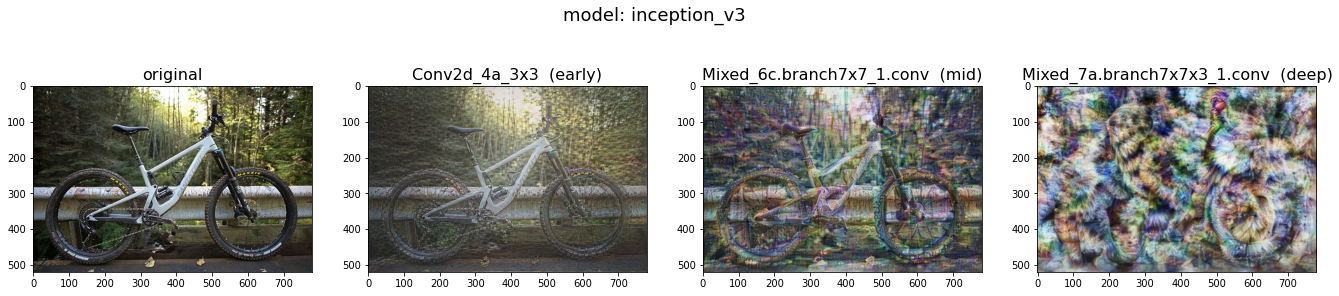

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (23,5))
fig.suptitle('model: inception_v3',fontsize = 18)

ax.flat[0].imshow(im)    
ax.flat[0].set_title('original', fontsize = 16)
for i in range(1,4):
    ax.flat[i].imshow(img_params[i-1])
    ax.flat[i].set_title(layer_names[i-1],fontsize = 16)

# Experiment 2: on resnet 

In [ ]:
model = models.resnet50(pretrained=True)

dreamy_boi = dreamer(model, device = 'cuda', quiet= False)

layers_to_watch = [
                 model.layer1[0].conv1,
                 model.layer3[2].conv1,
                 model.layer4[2].conv2
            ]

In [ ]:
img_params = []

for layer in layers_to_watch:
    # Capture and store the outputs of the layers mentioned in arg layers
    snapshot = dreamy_boi.get_snapshot(
        layers = [layer],
        input_tensor = image_tensor_transformed
    )

    snap_loss = SnapshotLoss(ideal_layer_outputs = snapshot)

    img_param = dreamy_boi.render(
        layers= [layer],
        custom_func= snap_loss,
        iters = 190,
        height= height,
        width= width,
        # weight_decay= 1e-3,
        lr = 7e-3,
        scale_min= 0.8,
        rotate_degrees= 0
    )
    img_params.append(img_param)

100%|██████████| 190/190 [00:12<00:00, 15.57it/s]


In [ ]:
layer_names =  [
                 "layer1[0].conv1  (early)",
                 "layer3[2].conv1  (mid)",
                 "layer4[2].conv2  (deep)"
            ]

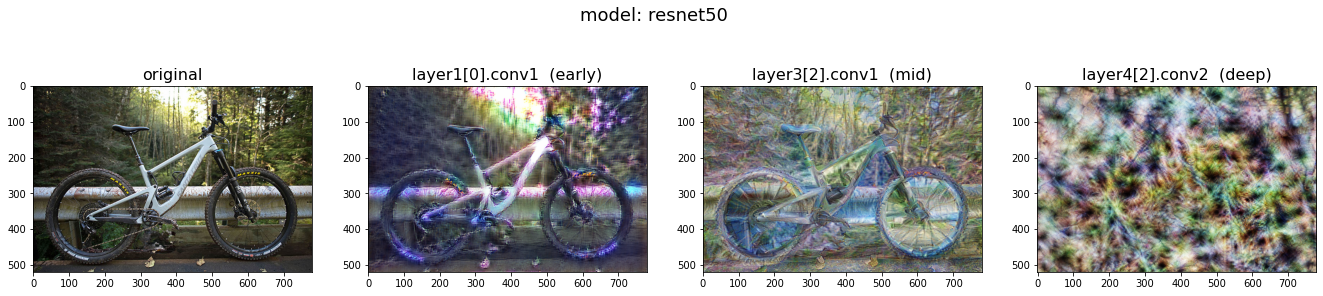

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (23,5))
fig.suptitle('model: resnet50',fontsize = 18)

ax.flat[0].imshow(im)    
ax.flat[0].set_title('original', fontsize = 16)
for i in range(1,4):
    ax.flat[i].imshow(img_params[i-1])
    ax.flat[i].set_title(layer_names[i-1],fontsize = 16)